<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [161]:
%%capture
pip install pyswarms

In [162]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [163]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [164]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [165]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [166]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [167]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [168]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [169]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [170]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [171]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [172]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [173]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


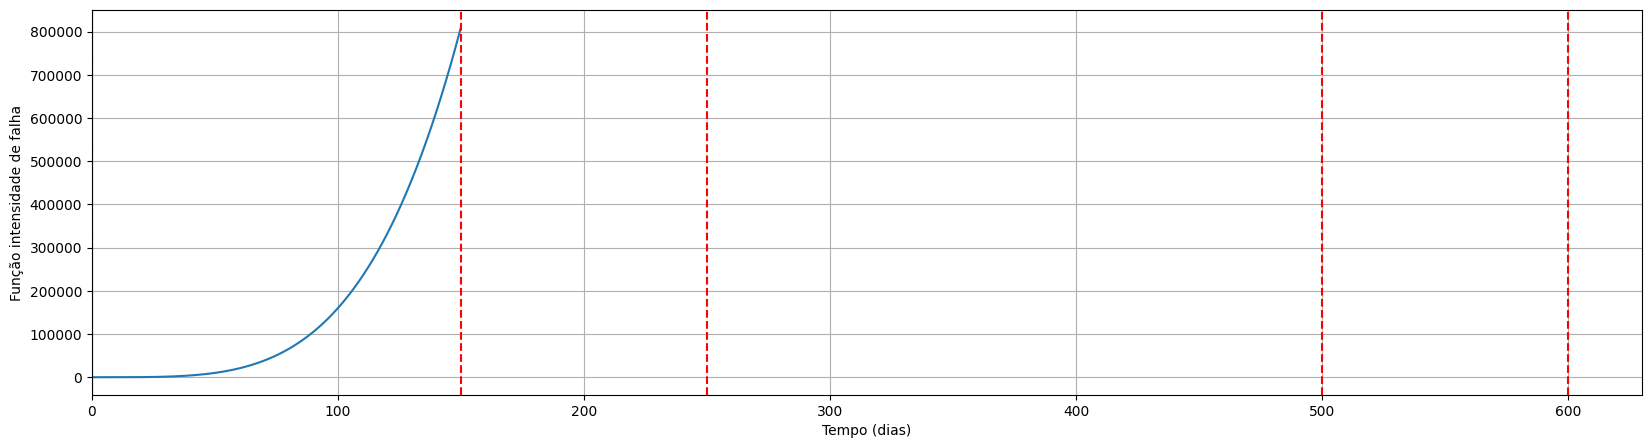

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [174]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [175]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):
    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    global s
    T = [0]
    s_row = []
    cont = 0

    # Iterar sobre os elementos de x usando np.nditer()
    with np.nditer(x, op_flags=['readwrite']) as it:
        for number in it:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

# A partir da solução define o número de ciclos
# A variável m é o número de sistemas em análise: em nosso exemplo m = 4
# Para novos dados esse parâmetro deve ser ajustado
# m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

# O modelo já está ajustado
# Utilizado para avaliar a solução candidata

# Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

# Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

# Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)

    print('Custo = ', Custo)

    # Retorna o custo
    return Custo

In [176]:
num_particles = 10
max_iterations = 100
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-08-25 14:18:03,712 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/100, best_cost=4.04e+11<ipython-input-175-5db6df258298>:79: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:   9%|▉         |9/100, best_cost=1.46e+11



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 29, 48, 90, 183, 306, 346, 388, 436, 468, 507, 542, 620, 636, 769, 802]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 6563.56768, 32530.354576490823, 273805.9553095757, 22526627.498998582, 60260957.049305424, 176783208.57386047, 210580868.39298415, 223148745.40977255, 231918325.84376994, 317876480.91372144, 334767765.73279816, 2668483943.358767, 2680295014.1025243, 11968322711.851665, 12395165394.508614, 11856391599.962605]
Custo =  513614904284.0014


Número de ciclos d

pyswarms.single.global_best:  35%|███▌      |35/100, best_cost=1.46e+11



Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 0, 70, 95, 153, 257, 297, 348, 362, 425, 457, 518, 543, 609, 635, 710, 726, 751, 799]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.0, 537824.0, 572910.1414723251, 2776277.5761150694, 18857891.319965523, 30549255.399613053, 59394765.9245927, 60560621.78447826, 140126241.58373243, 148174016.5808076, 307251631.8121393, 318221653.09176344, 640653382.4162748, 661406767.0079257, 1334477948.1554337, 135

pyswarms.single.global_best:  45%|████▌     |45/100, best_cost=1.43e+11

Custo =  223575624893.20285


Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 156, 180, 254, 273, 345, 360, 433, 455, 518, 540, 610, 630, 701, 722, 792, 813, 870]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 3590576.488866934, 3799308.042026725, 20736856.294365868, 21343911.429098446, 66852769.73801796, 68094487.00682113, 172152305.7296461

pyswarms.single.global_best:  66%|██████▌   |66/100, best_cost=1.43e+11



Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 161, 255, 342, 361, 429, 454, 519, 542, 610, 630, 702, 722, 789, 813, 882]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4328976.966048022, 16156497.537707504, 75669430.56096053, 85961833.12402508, 177218476.35922456, 182852083.01056808, 356420186.72195256, 366243545.6367876, 702796346.0979662, 717516564.3567951, 1331154686.7103858, 135600646

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.43e+11
2023-08-25 14:18:04,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819619 2.76163181 3.35288155]
2023-08-25 14:18:04,711 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 93, 160, 257, 273, 343, 361, 429, 457, 519, 542, 610, 633, 701, 722, 790, 875]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 552469.4420357683, 3936279.6553931395, 17085669.225562017, 19950875.712805975, 62695735.205245584, 72398845.9162192, 163655489.1514187, 170360569.4895595, 333886236.1020354, 343709595.01687044, 680262395.478049, 697945045.412171, 1267728382.57

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,720 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03800494 2.76191262 3.35290381]
2023-08-25 14:18:04,721 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 158, 254, 341, 361, 428, 456, 519, 541, 610, 634, 704, 723, 791, 876]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 3809652.7766987435, 16258080.532677144, 75189712.40634957, 86077448.27615568, 174758434.49113047, 181409998.0378822, 348255716.03052706, 357493641.88288283, 700168034.776941, 718889079.120686, 1318472877.1360831, 1342035277.065345, 2245707808.6544857, 25

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,732 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03822347 2.76186511 3.35290445]
2023-08-25 14:18:04,733 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 159, 255, 283, 341, 361, 428, 455, 519, 541, 610, 634, 704, 724, 791, 877]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4082598.1085061356, 16636786.746128693, 22893292.740147855, 54805318.559966356, 65693054.42977247, 154374040.64474726, 160659376.9338391, 330852478.7016833, 340090404.55403906, 682764797.4480972, 701485841.7918423, 130106963

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,741 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03841936 2.76177106 3.3529038 ]




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 159, 254, 340, 361, 429, 454, 519, 540, 610, 633, 703, 725, 791, 878]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4082598.1085061356, 16165893.979249205, 73420070.93339281, 84909298.7981192, 176165942.0333187, 181799548.68466222, 355367652.3960467, 364036893.92472696, 712875288.6627967, 730557938.5969187, 1326913384.0806723, 1355100610.7873826, 2227872636.0881877, 2

2023-08-25 14:18:04,743 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,751 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03856571 2.76166889 3.35289941]
2023-08-25 14:18:04,752 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 160, 253, 340, 361, 430, 452, 519, 540, 610, 632, 701, 724, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4259970.067085848, 15540844.418465558, 73895557.1034913, 85384784.9682177, 179268906.19404572, 183971127.35220006, 364373239.0575422, 373042480.58622247, 721880875.3242922, 738550910.441199, 1318382018.5896, 1347911443.3621802, 2216456933.3938, 259033268

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,761 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03864388 2.76157026 3.35289209]
2023-08-25 14:18:04,762 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 160, 251, 339, 361, 431, 450, 520, 540, 610, 631, 700, 724, 790, 817, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4259970.067085848, 14689749.379543055, 73577272.37015064, 85674268.9550088, 182238467.19773418, 186090016.88775238, 378323597.2475021, 386497918.9196623, 735336313.657732, 751019030.5317634, 1327712732.4172425, 1358754380.8

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,771 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03865122 2.76148757 3.35288397]
2023-08-25 14:18:04,772 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 161, 181, 249, 285, 339, 361, 431, 520, 540, 610, 630, 699, 722, 789, 824, 883]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4444358.0649927305, 4600253.2304411605, 18311721.348961264, 20201352.28176312, 48508522.04965412, 126405858.70262668, 222970056.94535202, 289999259.11115634, 342800081.3447138, 691638476.08278

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,779 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03856738 2.76142384 3.35287639]
2023-08-25 14:18:04,780 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 161, 182, 248, 271, 339, 361, 432, 520, 540, 610, 699, 721, 789, 828, 884]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4444358.0649927305, 4616472.911370416, 17479982.35119204, 18257931.430103548, 57544372.330228135, 69641368.9150863, 168939029.00613478, 234488453.15744543, 287289275.3910029, 636127670.1290727, 806156574.052938, 988755671.52

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,789 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03845478 2.76141055 3.35286984]
2023-08-25 14:18:04,791 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 161, 183, 247, 339, 361, 432, 521, 540, 611, 698, 720, 789, 831, 884]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4444358.0649927305, 4633873.272283092, 16689234.302033093, 38576461.54482369, 50673458.12968185, 149971118.22073033, 217390367.40265507, 267395909.59068948, 624631458.5819778, 787351319.6812904, 968952101.3744547, 1879327195.8902583, 1982945869.7302353, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,799 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03831027 2.76141635 3.35286699]
2023-08-25 14:18:04,800 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 161, 183, 246, 292, 339, 361, 432, 521, 540, 610, 698, 789, 830, 885]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4444358.0649927305, 4633873.272283092, 16220577.439320708, 19406090.833416387, 42927203.27544918, 44974782.23428217, 144272442.32533064, 211691691.50725538, 261697233.6952898, 610535628.4333596, 776492267.8427379, 2047322897.4424508, 2664417890.019136, 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,905 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03817306 2.76147873 3.35286618]
2023-08-25 14:18:04,906 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 161, 183, 245, 340, 361, 431, 521, 540, 610, 698, 790, 826, 884]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4328976.966048022, 4518492.173338383, 15650705.4159586, 39525848.79189734, 51015076.656623736, 147579274.8993491, 216509926.59104097, 266515468.77907538, 615353863.5171452, 781310502.9265234, 2075682688.686631, 2601810334.8881245, 3758419058.5939274, 3662923629.001127]
Custo =  247765

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,915 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03805351 2.76157718 3.35286686]
2023-08-25 14:18:04,916 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 182, 245, 341, 361, 431, 521, 540, 610, 698, 790, 820, 883]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4335162.025596766, 15764997.780407168, 40453770.02444633, 51341505.89425244, 147905704.1369778, 216836355.82866967, 266841898.01670408, 615680292.7547739, 781636932.1641521, 2076009117.9242597, 2496816285.2452226, 3760914618.795647, 3665962881.373054]
Custo =  2459

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,924 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03797045 2.76168118 3.35286901]
2023-08-25 14:18:04,925 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 247, 288, 341, 361, 430, 520, 541, 610, 699, 790, 813, 882]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 17010333.033751223, 19472224.012550745, 47667184.86668821, 118698040.83791946, 212582162.06374747, 281115382.53345364, 337135839.3096689, 679810232.203727, 849839136.1275923, 2126732458.3391693, 2434235842.68162, 38

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.43e+11



Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 248, 272, 341, 361, 430, 520, 541, 610, 700, 720, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 17832910.42192726, 18672669.59521021, 59659819.777186744, 70547555.64699286, 164431676.87282088, 232964897.34252706, 288985354.11874235, 631659747.0128005, 805833922.5577676, 970179747.552695, 1900555660.093885, 227

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,935 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03794323 2.7617639  3.35287347]
2023-08-25 14:18:04,936 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.43e+11



Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 159, 180, 250, 341, 361, 429, 450, 520, 541, 610, 630, 701, 720, 790, 879]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 3976006.158956128, 4141900.6092129806, 18742635.736322057, 40373083.90922912, 51260819.77903523, 142517463.01423472, 146878845.93111545, 339112426.2908651, 347842670.8004909, 690517063.6945491, 705237281.953378, 1305342031.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,944 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03791914 2.76180855 3.35287791]
2023-08-25 14:18:04,946 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.43e+11



Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 159, 251, 341, 361, 429, 451, 520, 541, 610, 631, 701, 721, 791, 878]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 3976006.158956128, 14730631.949662503, 77078577.89823993, 87966313.76804604, 179222957.00324553, 183886463.56938177, 372579363.21285987, 381309607.72248566, 723984000.6165438, 739666717.4905752, 1329604798.5621085, 1354324214.92256, 2289213121.0866466, 2

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,954 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0379692 2.7618326 3.3528824]
2023-08-25 14:18:04,955 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.43e+11



Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 159, 252, 340, 361, 429, 452, 520, 541, 610, 632, 702, 722, 790, 877]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 3976006.158956128, 15159842.493734661, 74629325.03878616, 86118552.90351255, 177375196.13871205, 182351268.21299765, 367532683.0203955, 376262927.5300213, 718937320.4240794, 735607355.5409862, 1328747573.984614, 1353599356.3233764, 2252902617.3186936, 26

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03803382 2.76183123 3.35288626]
2023-08-25 14:18:04,965 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.43e+11



Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 159, 253, 284, 340, 361, 429, 453, 520, 541, 610, 632, 702, 722, 790, 876]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 3976006.158956128, 15602626.053239625, 22776648.23849474, 52851509.21115489, 127320117.77633564, 218576761.0115351, 223876108.80914408, 405574941.3884216, 414305185.8980474, 756979578.7921054, 773649613.9090122, 1366789832.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,975 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03812566 2.76180393 3.3528884 ]
2023-08-25 14:18:04,976 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,983 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03821564 2.76173047 3.35288921]
2023-08-25 14:18:04,985 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 159, 180, 252, 272, 340, 361, 430, 453, 520, 541, 610, 632, 702, 722, 790, 877]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 3976006.158956128, 4141900.6092129806, 19877239.54619519, 20521030.74375144, 60216430.014228106, 71705657.8789545, 165589779.10478252, 170606932.12376314, 352305764.70304066, 361036009.21266645

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:04,993 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03829134 2.76165917 3.35288942]
2023-08-25 14:18:04,994 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 160, 180, 252, 272, 339, 361, 430, 452, 520, 540, 610, 632, 701, 722, 790, 878]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4259970.067085848, 4412988.268189513, 20148327.205171723, 20792118.402727973, 59226148.009660766, 61273726.96849376, 155157848.19432178, 159860069.35247612, 345041484.159874, 353215805.8320342

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,002 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0383508  2.76158927 3.3528885 ]
2023-08-25 14:18:05,004 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 160, 181, 251, 339, 361, 431, 451, 520, 540, 610, 632, 701, 722, 790, 813, 879]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4259970.067085848, 4428952.92216163, 19222001.692698784, 38863136.073210746, 50960132.6580689, 147524330.90079427, 151662302.09652227, 340355201.74000037, 348529523.4121606, 697367918.1502304,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,012 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03836968 2.76153036 3.35288657]
2023-08-25 14:18:05,013 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 160, 181, 250, 273, 340, 361, 431, 451, 520, 540, 610, 631, 700, 722, 790, 817, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4259970.067085848, 4428952.92216163, 18673234.94594298, 19471576.398560077, 58306694.558644794, 132775303.12382555, 229339501.36655092, 233477472.56227893, 42217

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,021 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03835567 2.76149845 3.3528836 ]
2023-08-25 14:18:05,023 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 160, 181, 249, 272, 340, 361, 431, 450, 520, 540, 610, 631, 699, 721, 790, 819, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4259970.067085848, 4428952.92216163, 18140421.040681735, 18928516.386686, 58623915.65716267, 70113143.52188906, 166677341.7646144, 170528891.4546326, 362762471.81

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,031 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03830591 2.76149586 3.35288078]
2023-08-25 14:18:05,032 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 161, 182, 249, 270, 340, 361, 431, 450, 520, 540, 610, 630, 699, 720, 790, 821, 882]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4444358.0649927305, 4616472.911370416, 17987509.54278626, 18659771.88103059, 60109695.51775436, 62034322.28021666, 158598520.522942, 162450070.2129602, 354683650

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03825357 2.76149709 3.35287841]
2023-08-25 14:18:05,042 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 90, 161, 182, 248, 340, 361, 431, 520, 540, 610, 630, 699, 720, 790, 820, 882]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 543327.3025771828, 4444358.0649927305, 4616472.911370416, 17479982.35119204, 39531615.48450717, 51020843.34923357, 147585041.59195894, 214614243.75776327, 267415065.9913207, 616253460.7293905, 630973678.9882194, 1204542792.093717, 1230550704.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,050 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819169 2.76152329 3.35287677]
2023-08-25 14:18:05,051 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 161, 182, 248, 271, 341, 361, 431, 450, 520, 541, 610, 630, 699, 790, 817, 882]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4328976.966048022, 4501091.8124257075, 17364601.25224733, 18142550.33115884, 60020738.94926837, 131051594.92049962, 227615793.163225, 231467342.8532432, 423700923.2129929, 432431167.7226187, 7

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,337 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03813648 2.76156651 3.35287639]
2023-08-25 14:18:05,339 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 161, 182, 248, 341, 361, 430, 450, 520, 541, 610, 630, 699, 790, 813, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4328976.966048022, 4501091.8124257075, 17364601.25224733, 40180517.06638385, 51068252.936189964, 144952374.162018, 149055970.78979135, 341289551.149541, 350019795.6591668, 692694188.5532249, 707414406.8120538, 1280983519.91

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03809492 2.76161129 3.35287753]
2023-08-25 14:18:05,358 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 182, 248, 341, 361, 430, 450, 520, 541, 610, 630, 700, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4335162.025596766, 17198671.465418387, 40014587.2795549, 50902323.149361014, 144786444.37518904, 148890041.00296238, 341123621.362712, 349853865.8723378, 692528258.7663959, 707248477.0252248, 1293997474.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,374 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03806975 2.76165241 3.35287915]
2023-08-25 14:18:05,375 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 248, 340, 361, 430, 451, 520, 541, 610, 630, 700, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 17512287.202995364, 39563920.3363105, 51053148.2010369, 144937269.42686492, 149335060.06830603, 338027959.7117841, 346758204.2214099, 689432597.115468, 704152815.3742969, 1290901812.9675179, 1550564472.485097, 34435

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,397 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03808043 2.76168459 3.35288072]
2023-08-25 14:18:05,401 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 249, 340, 361, 430, 451, 520, 541, 610, 631, 701, 790, 879]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18029498.63845581, 39498158.76114746, 50987386.62587386, 144871507.8517019, 149269298.493143, 337962198.1366211, 346692442.6462469, 689366835.540305, 705049552.4143364, 1294987633.48587, 1549899709.9849248, 34094735

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,416 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03811211 2.76170129 3.35288225]
2023-08-25 14:18:05,423 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 249, 340, 361, 430, 451, 520, 541, 610, 631, 701, 720, 790, 879]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 18359944.035692062, 39828604.15838371, 51317832.02311011, 145201953.24893814, 149599743.89037925, 338292643.53385735, 347022888.04348314, 689697280.9375412, 705379997.8115727, 1295318

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,438 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03816349 2.76169898 3.35288347]
2023-08-25 14:18:05,443 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 250, 340, 361, 430, 451, 520, 541, 610, 631, 701, 720, 790, 879]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 18902800.993072666, 39800593.18140558, 51289821.04613198, 145173942.27196002, 149571732.91340113, 338264632.5568792, 346994877.066505, 689669269.9605632, 705351986.8345946, 1295290067

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,458 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03821451 2.76169148 3.35288408]
2023-08-25 14:18:05,459 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 251, 340, 361, 430, 452, 520, 541, 610, 632, 701, 721, 790, 879]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 19461834.95243952, 39800671.28084934, 51289899.14557573, 145174020.37140375, 149876241.5295581, 335057656.336956, 343787900.8465818, 686462293.7406399, 703132328.8575467, 1282963437.0

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,472 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03825565 2.76167284 3.35288407]
2023-08-25 14:18:05,477 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 251, 278, 340, 361, 430, 451, 520, 541, 610, 632, 701, 721, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 19461834.95243952, 20546435.165856056, 55244144.31850282, 129712752.88368356, 223596874.10951158, 227994664.7509527, 416687564.39443076, 425417808.90405

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,490 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03827964 2.76165176 3.35288346]
2023-08-25 14:18:05,494 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 252, 340, 361, 430, 451, 520, 540, 610, 631, 700, 722, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 20037404.802945796, 39829006.37778841, 51318234.242514804, 145202355.46834284, 149600146.10978395, 338293045.75326204, 346467367.42542225, 695305762.163492, 710988479.0375234, 1287682

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,506 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0382972  2.76163188 3.35288269]
2023-08-25 14:18:05,510 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 252, 340, 361, 430, 451, 520, 540, 610, 631, 700, 722, 790, 811, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 20037404.802945796, 39829006.37778841, 51318234.242514804, 145202355.46834284, 149600146.10978395, 338293045.75326204, 346467367.42542225, 695305762.163

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,523 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03830988 2.76161396 3.35288166]
2023-08-25 14:18:05,526 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 251, 340, 361, 430, 451, 520, 540, 610, 631, 700, 722, 790, 813, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 19111079.29047286, 39449915.618882686, 50939143.48360908, 144823264.7094371, 149221055.3508782, 337913954.9943563, 346088276.6665165, 694926671.4045863, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,543 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03831028 2.7616015  3.35288071]
2023-08-25 14:18:05,548 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 251, 274, 340, 361, 430, 450, 520, 540, 610, 631, 700, 722, 790, 815, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 19111079.29047286, 19919767.34826858, 57905730.034715936, 132374338.59989668, 226258459.82572472, 230362056.45349807, 4225

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,564 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03830746 2.76159429 3.35287992]
2023-08-25 14:18:05,566 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 280, 340, 361, 430, 450, 520, 540, 610, 630, 699, 721, 790, 817, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 19875903.762137454, 52992512.04649764, 64481739.91122404, 158365861.13705206, 162469457.7648254, 354703

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,583 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03829754 2.76159561 3.35287943]
2023-08-25 14:18:05,584 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 249, 289, 340, 361, 430, 450, 520, 541, 610, 630, 699, 721, 790, 817, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18029498.63845581, 20409954.512093205, 46897224.30551058, 48821851.067972876, 142705972.2938009, 146809568.92157423, 33904

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,601 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03826849 2.76160375 3.35287902]
2023-08-25 14:18:05,603 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 249, 341, 361, 430, 450, 520, 541, 610, 630, 699, 720, 790, 816, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18029498.63845581, 40246502.79210956, 51134238.66191567, 145018359.88774368, 149121956.51551703, 341355536.8752667, 350085781.38489246, 692760174.2789506

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.43e+11



Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 249, 287, 340, 361, 430, 450, 520, 541, 610, 630, 700, 720, 790, 815, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18029498.63845581, 20154056.965041142, 48048691.78689414, 59537919.65162054, 153422040.87744856, 157525637.5052219, 3497592

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,620 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03823119 2.76161547 3.35287905]
2023-08-25 14:18:05,625 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,824 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819756 2.76163035 3.35287917]
2023-08-25 14:18:05,825 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 249, 340, 361, 430, 450, 520, 541, 610, 630, 700, 720, 790, 813, 879]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18029498.63845581, 39498158.76114746, 50987386.62587386, 144871507.8517019, 148975104.47947523, 341208684.83922493, 349938929.3488507, 692613322.2429088,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,834 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0381672  2.76164397 3.35287965]
2023-08-25 14:18:05,835 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 248, 340, 361, 430, 451, 520, 541, 610, 630, 700, 790, 811, 879]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 17512287.202995364, 39563920.3363105, 51053148.2010369, 144937269.42686492, 149335060.06830603, 338027959.7117841, 346758204.2214099, 689432597.115468, 704152815.3742969, 1290901812.96

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,844 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0381421  2.76165559 3.35288055]
2023-08-25 14:18:05,845 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 248, 272, 340, 361, 430, 451, 520, 541, 610, 630, 700, 790, 879]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 17512287.202995364, 18352046.376278315, 58047445.64675498, 59972072.409217276, 153856193.6350453, 158253984.2764864, 346946883.9199645, 355677128.4295903, 698351521.3236485, 713071739.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03811977 2.76166294 3.35288165]
2023-08-25 14:18:05,855 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 249, 340, 361, 430, 451, 520, 541, 610, 630, 700, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18029498.63845581, 39498158.76114746, 50987386.62587386, 144871507.8517019, 149269298.493143, 337962198.1366211, 346692442.6462469, 689366835.540305, 704087053.7991339, 1290836051.392355, 1550498710.909934, 34434786

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,864 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03811245 2.76166255 3.35288262]
2023-08-25 14:18:05,865 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 249, 298, 340, 361, 430, 451, 520, 541, 610, 631, 700, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 18359944.035692062, 22189665.081573687, 42770250.55944239, 54259478.424168795, 148143599.64999682, 152541390.29143792, 341234289.934916, 349964534.4445418, 692638927.3385999, 708321644

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,874 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0381259  2.76166116 3.35288347]
2023-08-25 14:18:05,875 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 18902800.993072666, 39800593.18140558, 51289821.04613198, 145173942.27196002, 149571732.91340113, 338264632.5568792, 346994877.066505, 689669269.9605632, 705351986.8345946, 1282045688.7200737, 1541708348.2376528, 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,883 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0381533  2.76165262 3.35288416]
2023-08-25 14:18:05,884 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 250, 275, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 18902800.993072666, 19830835.838669624, 56978623.57532252, 68467851.44004892, 162351972.66587692, 166749763.30731803, 355442662.9507961, 364172907.460421

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03818305 2.76163972 3.35288459]
2023-08-25 14:18:05,893 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 251, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 19461834.95243952, 39800671.28084934, 51289899.14557573, 145174020.37140375, 149571811.01284486, 338264710.65632296, 346994955.16594875, 689669348.0600069, 705352064.9340383, 12820457

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,901 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03821349 2.76162806 3.35288467]
2023-08-25 14:18:05,902 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 251, 297, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 19111079.29047286, 22468796.578476585, 43672919.39603518, 118141527.96121593, 212025649.18704396, 216423439.82848507, 405116339.47196317, 413846583.98158

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,911 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03823716 2.76161837 3.35288382]
2023-08-25 14:18:05,912 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 251, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 19111079.29047286, 39449915.618882686, 50939143.48360908, 144823264.7094371, 149221055.3508782, 337913954.9943563, 346644199.50398207, 689318592.3980402, 705001309.2720716, 1281695011.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,920 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03824884 2.76161175 3.35288295]
2023-08-25 14:18:05,921 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 251, 340, 361, 430, 450, 520, 541, 610, 631, 700, 721, 790, 810, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 19111079.29047286, 39449915.618882686, 50939143.48360908, 144823264.7094371, 148926861.33721045, 341160441.6969601, 349890686.2065859, 692565079.100644, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,929 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03824769 2.76160724 3.35288211]
2023-08-25 14:18:05,931 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 251, 276, 340, 361, 430, 450, 520, 541, 610, 631, 700, 721, 790, 811, 881]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 19111079.29047286, 20050917.47887072, 56371366.62840984, 130839975.19359058, 224724096.4194186, 228827693.04719195, 421061

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,939 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03824381 2.76160599 3.35288127]
2023-08-25 14:18:05,940 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 251, 293, 340, 361, 430, 450, 520, 541, 610, 630, 700, 721, 790, 812, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 19111079.29047286, 21828139.330535866, 45606630.92116588, 57095858.78589228, 150979980.0117203, 155083576.63949364, 3473171

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,948 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03823889 2.76161234 3.35288053]
2023-08-25 14:18:05,949 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 251, 340, 361, 430, 451, 520, 541, 610, 630, 700, 721, 790, 812, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 19111079.29047286, 39449915.618882686, 50939143.48360908, 144823264.7094371, 149221055.3508782, 337913954.9943563, 346644199.50398207, 689318592.3980402,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:05,958 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03822847 2.76161841 3.35288007]
2023-08-25 14:18:05,959 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 274, 340, 361, 430, 451, 520, 541, 610, 630, 700, 721, 790, 813, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 19423875.489627216, 57409838.17607458, 131878446.74125533, 225762567.96708333, 230160358.60852444, 418

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 630, 700, 721, 790, 812, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

2023-08-25 14:18:06,141 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03821652 2.76162589 3.35287976]
2023-08-25 14:18:06,143 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,151 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03820296 2.76163334 3.3528796 ]




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 249, 340, 361, 430, 451, 520, 541, 610, 630, 700, 721, 790, 812, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18029498.63845581, 39498158.76114746, 50987386.62587386, 144871507.8517019, 149269298.493143, 337962198.1366211, 346692442.6462469, 689366835.540305, 704

2023-08-25 14:18:06,152 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,160 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03818963 2.76163994 3.35287947]
2023-08-25 14:18:06,162 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 249, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18029498.63845581, 39498158.76114746, 50987386.62587386, 144871507.8517019, 149269298.493143, 337962198.1366211, 346692442.6462469, 689366835.540305, 705

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,170 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03817834 2.76164504 3.3528796 ]
2023-08-25 14:18:06,171 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 249, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18029498.63845581, 39498158.76114746, 50987386.62587386, 144871507.8517019, 149269298.493143, 337962198.1366211, 346692442.6462469, 689366835.540305, 705

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,179 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03817089 2.76164897 3.35287986]
2023-08-25 14:18:06,180 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 249, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18029498.63845581, 39498158.76114746, 50987386.62587386, 144871507.8517019, 149269298.493143, 337962198.1366211, 346692442.6462469, 689366835.540305, 705

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,188 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03816918 2.76164739 3.35288032]
2023-08-25 14:18:06,190 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 180, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4302065.8659635885, 18902800.993072666, 39800593.18140558, 51289821.04613198, 145173942.27196002, 149571732.91340113, 338264632.5568792, 346994877.066505, 689669269.9605632, 705351986.8345946, 1282045688

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,203 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.038173   2.76164386 3.35288097]
2023-08-25 14:18:06,204 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.5112075, 705011498.3852389, 128170520

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03817703 2.76163873 3.35288157]
2023-08-25 14:18:06,214 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.5112075, 705011498.3852389, 128170520

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,222 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03818438 2.76163384 3.35288211]
2023-08-25 14:18:06,225 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 275, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 19490347.38931401, 56638135.12596691, 68127362.9906933, 162011484.21652132, 166409274.85796243, 3551021

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,232 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819155 2.76162933 3.35288254]
2023-08-25 14:18:06,234 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 291, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 21106757.841931857, 46222326.39631443, 48146953.15877672, 142031074.38460475, 146428865.02604586, 3351

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,242 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819869 2.76162539 3.35288273]
2023-08-25 14:18:06,243 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,251 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03820508 2.76162288 3.35288256]
2023-08-25 14:18:06,252 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,260 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03820817 2.76162189 3.35288219]
2023-08-25 14:18:06,261 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,269 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03820891 2.76162282 3.35288173]
2023-08-25 14:18:06,270 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03820956 2.76162518 3.35288128]
2023-08-25 14:18:06,279 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 630, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,287 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03820971 2.76162797 3.35288094]
2023-08-25 14:18:06,288 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 630, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.43e+11



Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 285, 340, 361, 430, 451, 520, 541, 610, 630, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 20362630.61021369, 49701347.999789774, 124169956.56497052, 218054077.79079854, 222451868.43223965, 411

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,571 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0382068  2.76163161 3.35288069]
2023-08-25 14:18:06,573 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,589 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0382023  2.76163495 3.35288054]
2023-08-25 14:18:06,591 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 273, 340, 361, 430, 451, 520, 541, 610, 630, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 19360653.99633415, 58195772.15641887, 69685000.02114527, 163569121.24697328, 167966911.88841438, 356659

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,604 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819754 2.7616372  3.35288048]
2023-08-25 14:18:06,608 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 271, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 19243482.491594043, 59810434.57801257, 61735061.34047487, 155619182.5663029, 160016973.207744, 3487098

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,622 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819304 2.76163849 3.35288049]
2023-08-25 14:18:06,624 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,639 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03818987 2.76163798 3.35288069]
2023-08-25 14:18:06,643 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 273, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 19360653.99633415, 58195772.15641887, 132664380.72159961, 226548501.94742763, 230946292.58886874, 4196

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03818773 2.76163733 3.3528811 ]
2023-08-25 14:18:06,659 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,678 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03818743 2.76163562 3.35288152]
2023-08-25 14:18:06,679 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,693 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0381897  2.76163322 3.3528819 ]
2023-08-25 14:18:06,694 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 292, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 21250069.833977893, 45692836.28923911, 47617463.051701404, 141501584.27752942, 145899374.91897053, 334

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819291 2.76163068 3.35288221]
2023-08-25 14:18:06,711 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,727 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819613 2.76162865 3.35288239]
2023-08-25 14:18:06,728 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,743 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819904 2.76162715 3.35288246]
2023-08-25 14:18:06,745 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,761 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03820089 2.76162582 3.35288227]
2023-08-25 14:18:06,763 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,779 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03820156 2.76162564 3.35288189]
2023-08-25 14:18:06,780 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,795 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03820152 2.76162571 3.35288155]




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 282, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 20057453.12362708, 51633480.22029486, 126102088.78547561, 219986210.01130363, 224384000.65274474, 4130

2023-08-25 14:18:06,798 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,813 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0382004  2.76162728 3.35288124]
2023-08-25 14:18:06,821 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 285, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 20362630.61021369, 49701347.999789774, 61190575.86451617, 155074697.0903442, 159472487.7317853, 3481653

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:06,831 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819884 2.76162985 3.35288097]
2023-08-25 14:18:06,834 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 293, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 21399365.757719632, 45177857.348349646, 47102484.11081194, 140986605.33663997, 145384395.97808108, 334

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:07,334 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819667 2.76163221 3.35288085]
2023-08-25 14:18:07,344 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


[0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.5112075, 705011498.3852389, 1281705200.270718, 1307852282.0945942, 2222652204.973467, 2263798564.0040474, 3648024711.4926386, 3554691511.067083]
Custo =  227967749306.10034


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:07,441 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819462 2.76163429 3.35288075]




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

2023-08-25 14:18:07,490 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:07,562 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819319 2.76163556 3.35288087]
2023-08-25 14:18:07,565 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:07,594 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819256 2.76163567 3.35288111]




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

2023-08-25 14:18:07,598 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:07,628 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819209 2.76163477 3.35288146]
2023-08-25 14:18:07,634 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 273, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 19360653.99633415, 58195772.15641887, 132664380.72159961, 226548501.94742763, 230946292.58886874, 4196

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:07,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819287 2.76163344 3.35288177]
2023-08-25 14:18:07,668 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:07,687 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819427 2.76163217 3.35288204]
2023-08-25 14:18:07,690 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 289, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 20837362.523225047, 47324632.31664242, 58813860.18136881, 152697981.40719682, 157095772.04863793, 34578

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:07,710 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819563 2.76163094 3.35288226]
2023-08-25 14:18:07,712 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 270, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 810, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 19189300.136203274, 60639223.772927046, 62563850.53538934, 156447971.76121736, 160845762.40265846, 349

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:07,748 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0381969  2.76162988 3.35288244]
2023-08-25 14:18:07,750 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 720, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11



Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 39460104.73204997, 50949332.596776366, 144833453.8226044, 149231244.4640455, 337924144.10752356, 346654388.61714935, 689328781.511207


2023-08-25 14:18:07,783 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.038198   2.76162902 3.35288258]
2023-08-25 14:18:07,791 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.43e+11



Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 287, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 20589770.476290893, 48484405.29814389, 122953013.86332464, 216837135.08915266, 221234925.73059377, 409

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:07,821 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.0381985  2.76162904 3.35288242]
2023-08-25 14:18:07,826 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.43e+11



Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 1, 70, 91, 160, 181, 250, 282, 340, 361, 430, 451, 520, 541, 610, 631, 700, 721, 790, 811, 880]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 525277.7515387319, 546051.4751908119, 4149047.6648599235, 4318030.519935706, 18562312.543717053, 20057453.12362708, 51633480.22029486, 63122708.08502126, 157006829.31084928, 161404619.9522904, 3500975

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.43e+11
2023-08-25 14:18:07,851 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 143304585850.20178, best pos: [5.03819837 2.76162945 3.35288208]


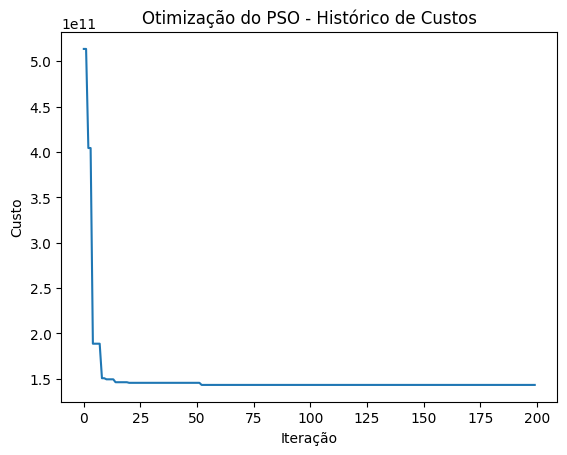

In [177]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.title('Otimização do PSO - Histórico de Custos')
plt.show()

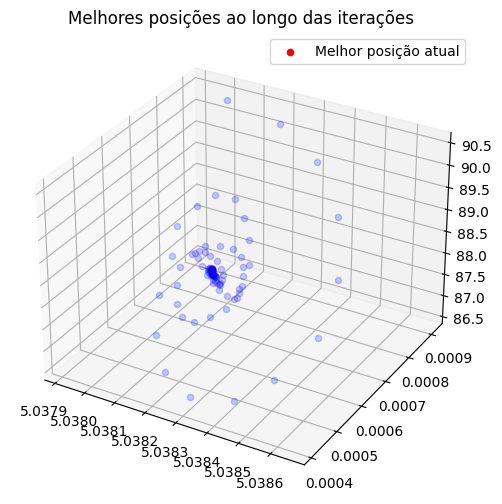

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 10
Número de Dimensões: 3
                              
Melhor partícula: 229403508305.3338


In [178]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])